# Imports

In [1]:
from loadfile import *
from phonemes import *
from preprocess import *
from evaluate import *
from google_kb_z_speaker.main import *
from tqdm.auto import tqdm
from experiment_helpers import *
from functools import partial
import numpy as np

2022-03-14 08:46:34,586.586 DEBUG __init__:  matplotlib data path: /home/nsmy/miniconda3/envs/speechTech/lib/python3.8/site-packages/matplotlib/mpl-data
2022-03-14 08:46:34,589.589 DEBUG __init__:  CONFIGDIR=/home/nsmy/.config/matplotlib
2022-03-14 08:46:34,591.591 DEBUG __init__:  interactive is False
2022-03-14 08:46:34,591.591 DEBUG __init__:  platform is linux
2022-03-14 08:46:34,592.592 DEBUG __init__:  loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_warnings', '_io', 'marshal', 'posix', '_frozen_importlib_external', '_thread', '_weakref', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', '_abc', 'abc', 'io', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_locale', '_bootlocale', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib.machinery', 'importlib.abc', '_operator', '

# Text processing

In [2]:
# Speaker
speakers = ["z21", "z20", "z28", "z29"]
models = ["google", "correct", "kb"]
models2fnameendings = {
    "google": "googleasr",
    "correct": "correct",
    "kb": "kb"
}
use_new = False

# Create filenames model -> List[List[str]] (List[str] are the lines from one filename
fnames = {model: [f"transcriptions{'_new' if use_new else ''}/{sp}.{models2fnameendings[model]}" for sp in speakers]
          for model in models}

bunches = {model: [get_fname_lines(fname) for fname in fnames] for model, fnames in fnames.items()}

# speakerLines : List[str]
# bunch List[speakerLines]
# bunches Dict[model, List[speakerLines]]

# Create a list [Dict[model,speakerlines] for speaker]

list_of_model2speaker_lines = [{model: bunch[i] for model, bunch in bunches.items()} for i in range(len(speakers))]
[fix_lines(x) for x in list_of_model2speaker_lines]
# recreate bunches Dict[model, List[speakerLines]]
bunches = {x: [list_of_model2speaker_lines[i][x] for i in range(len(speakers))] for x in models}
# Reduce bunches to bunches_reduced Dict[model, speakerLines_aggr]
bunches = {k: reduce(lambda x, y: x + y, v) for k, v in bunches.items()}
# Extract the transcriptions
bunches = {k: transcriptions(v) for k, v in bunches.items()}
# Preprocess  each transcription
bunches = {k: [preprocess_text(x) for x in v] for k, v in bunches.items()}

# Initialize phonemizer
phonemizer = init_phonemizer("cuda", "./models/deep-phonemizer-se.pt")

In [3]:
from IPython.core.debugger import set_trace

In [4]:
def singular_phonemes(txt : str):
    """
    Creates a list of singular phonemes from the
    output of get_swedish_phonemes
    """
    return txt.replace("_", " ").split()

def singular_phonemes_preprocess(bunches):
    return {k: [" ".join(singular_phonemes(s)) for s in v] for k,v in bunches.items()}

def get_swedish_phonemes_z(bunches, phonemizer,stress_marks=True):
    # Phonemizer creates a dict of words2phonemes for each line, so it 
    # so all phonemes should be created with a single call for consistency
    # Impose an order to models
    models = list(bunches.keys())
    num_lines = len(bunches["google"])
    concatenated = reduce(lambda x,y : x+y,[bunches[x] for x in models])
    phoneme_lines = get_swedish_phonemes(concatenated, phonemizer, "./models/stress_lex_mtm.txt", include_stress_marks=True)
    return { model : phoneme_lines[num_lines * i:num_lines * (i+1)] for model,i in zip(models,range(0,len(models)))}

# Experiments

In [5]:
def preprocess(bunches, _filter, phoneme_words, singular_phonemes, preprocess_hook, stress_marks):
    if phoneme_words:
        bunches = get_swedish_phonemes_z(bunches, phonemizer, stress_marks=stress_marks)
        #
        bunches = {k : [preprocess_phonemes(x) for x in v] for k,v in bunches.items()}
              
    if singular_phonemes:
        bunches = get_swedish_phonemes_z(bunches, phonemizer, stress_marks=stress_marks)
        bunches = singular_phonemes_preprocess(bunches)
    

    if preprocess_hook is not None:
        preprocess_hook(**locals())

    if _filter is not None:
        if len(_filter) == 1 and "agreement" in _filter:
            bunches = filter_bunches_only_on_agreement(bunches, _filter["agreement"])
        else:
            bunches = filter_bunches(bunches,**_filter)
        
    return {
        "bunches" : bunches
    }

def google_kb_wer(bunches):
    return {
        "google_wer" : wer(bunches["correct"], bunches["google"]),
        "kb_wer" : wer(bunches["correct"], bunches["kb"]),
    }
def sentence_lengths(bunches):
    return {k+"-avg-length" : mean([len(x.split(" ")) for x in v]) for k,v in bunches.items()}

def eoi(bunches):
    kei = 0
    oei = 0
    gei = 0
    tei = 0

    for c_l, g_l, kb_l in zip(bunches["correct"], bunches["google"], bunches["kb"]):
        g_s = set(error_idxs(c_l, g_l))
        k_s = set(error_idxs(c_l, kb_l))

        gei += len(g_s)
        kei += len(k_s)
        oei += len(g_s & k_s)
        tei += len(g_s | k_s)

    error_index_overlap = oei / tei
    
    return {"error_index_overlap": error_index_overlap}

def lcs_percentage(bunches):
    lcses = []
    
    for c_l, g_l, kb_l in zip(bunches["correct"], bunches["google"], bunches["kb"]):
        total_length_before = len(g_l.split(" ")) + len(kb_l.split(" "))
        words_set = set(g_l.split(" ") + kb_l.split(" "))
        w2char = { x : chr(i) for i,x in enumerate(words_set)}
        g_l_enc = "".join([w2char[w] for w in g_l.split(" ")])
        kb_l_enc = "".join([w2char[w] for w in kb_l.split(" ")])
        assert total_length_before == (len(g_l_enc) + len(kb_l_enc))
        
        s = SequenceMatcher(None, g_l_enc, kb_l_enc)
        lcs = ''.join([g_l_enc[block.a:(block.a + block.size)] for block in s.get_matching_blocks()])
        lcses.append(len(lcs)/ len(c_l.split(" ")))
    
    return {"lcs-mean": mean(lcses)}
          
def agreement_stats_experiment(bunches): 
   
    agreement, g_correct_kb_not, kb_correct_g_not, agreement_not_correct, agreement_correct,\
    both_incorrect_disagreement =\
        agreement_stats(bunches)
    
    return {  
        "agreement" : agreement,
        "g_correct_kb_not " : g_correct_kb_not,
        "kb_correct_g_not " : kb_correct_g_not,
        "agreement_not_correct" :  agreement_not_correct,
        "both_incorrect_disagreement" : both_incorrect_disagreement,
    }

def parameterized_agreement(bunches, _filter=None, phoneme_words=None, singular_phonemes=None, 
                            preprocess_hook=None, stress_marks=None, trusted_model=None, threshold_range=None):
    """
    Trusted model: Which model to fall back to when there is no agreement
    """
    bunches = preprocess(bunches, _filter, phoneme_words, singular_phonemes, preprocess_hook, stress_marks)["bunches"]
    threshold_levels = np.linspace(*threshold_range)
    # bunches : DL
    wers= []
    agreement_ratios = []
    
    for t in threshold_levels:
        agreement_func = partial(bunch_agrees,threshold=t)
        bunch_list = [{k: bunches[k][i] for k in bunches} for i in range(len([x for x in bunches.values()][0]))]
        preds = []
        corrects = []
        count_agreement = 0
        for bunch in bunch_list:
            if agreement_func(bunch):
                preds.append(get_lcs_str(bunch))
                corrects.append(bunch["correct"])
                count_agreement += 1
    
        wers.append(wer(corrects, preds))
        agreement_ratios.append(count_agreement / len(bunches["correct"]))
    
    return {
        "agreement_wers" : wers,
        "threshold_levels" : threshold_levels,
        "agreement_ratios" : agreement_ratios,
    }
                
            
    
def meval(bunches, _filter=None, phoneme_words=None, singular_phonemes=None, preprocess_hook=None, stress_marks=None):
    bunches = preprocess(bunches, _filter, phoneme_words, singular_phonemes, preprocess_hook, stress_marks)["bunches"]
    res =  {**google_kb_wer(bunches), **sentence_lengths(bunches), **lcs_percentage(bunches)}
    if _filter is None:
        return {**agreement_stats_experiment(bunches), **res, **eoi(bunches)}
    else:
        return {**res}
    

In [6]:
experiment = parameterized_agreement
kwargs = {
    "_filter": None, 
    "phoneme_words" : False,
    "singular_phonemes" : False,
    "preprocess_hook" : None,
    "stress_marks" : False,
    "trusted_model" : "kb",
    "threshold_range" : (0,1)
}
res = experiment(bunches, **kwargs)

2022-03-14 08:46:41,229.229 DEBUG font_manager:  findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2022-03-14 08:46:41,230.230 DEBUG font_manager:  findfont: score(FontEntry(fname='/home/nsmy/miniconda3/envs/speechTech/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-03-14 08:46:41,230.230 DEBUG font_manager:  findfont: score(FontEntry(fname='/home/nsmy/miniconda3/envs/speechTech/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-03-14 08:46:41,230.230 DEBUG font_manager:  findfont: score(FontEntry(fname='/home/nsmy/miniconda3/envs/speechTech/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf', name='STIXNonUnicode', styl

2022-03-14 08:46:41,356.356 DEBUG font_manager:  findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2022-03-14 08:46:41,357.357 DEBUG font_manager:  findfont: score(FontEntry(fname='/home/nsmy/miniconda3/envs/speechTech/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-03-14 08:46:41,357.357 DEBUG font_manager:  findfont: score(FontEntry(fname='/home/nsmy/miniconda3/envs/speechTech/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-03-14 08:46:41,358.358 DEBUG font_manager:  findfont: score(FontEntry(fname='/home/nsmy/miniconda3/envs/speechTech/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf', name='STIXNonUnicode', styl

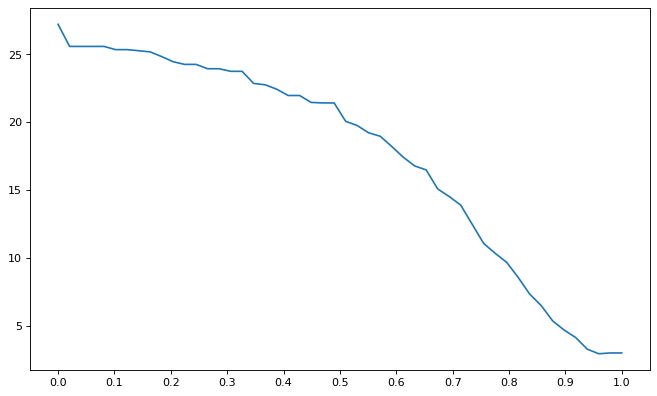

In [7]:
#fig, ax1 = plt.subplots()

#ax2 = ax1.twinx()
#ax2.set_ylim(0,100)
x = res["threshold_levels"]
y = res["agreement_wers"]

plt.figure(figsize=(10, 6), dpi=80)

plt.xticks(np.arange(min(x), max(x)+1, 0.1))
plt.plot(x, [yi * 100 for yi in y ])
#ax2.plot(res["threshold_levels"], [x * 100 for x in res["agreement_ratios"]], "r")
#plt.plot(res["threshold_levels"], [x * 10 for x in res["ensemble_wers"]])

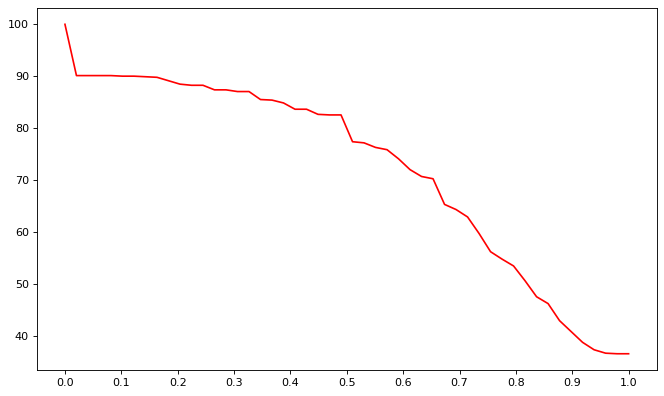

In [8]:
#fig, ax1 = plt.subplots()

#ax2 = ax1.twinx()
#ax2.set_ylim(0,100)
x = res["threshold_levels"]
y = res["agreement_ratios"]

plt.figure(figsize=(10, 6), dpi=80)

plt.xticks(np.arange(min(x), max(x)+1, 0.1))
plt.plot(x, [yi * 100 for yi in y ], "r")
#ax2.plot(res["threshold_levels"], [x * 100 for x in res["agreement_ratios"]], "r")
#plt.plot(res["threshold_levels"], [x * 10 for x in res["ensemble_wers"]])

In [17]:
experiment = meval
_filter = {
    "agreement" : False,
    "g_correct" : False,
    "kb_correct" : False,
}
kwargs = {
    "_filter": None, 
    "phoneme_words" : False,
    "singular_phonemes" : False,
    "preprocess_hook" : None,
    "stress_marks" : False
}
res = experiment_repeats(experiment, 5, bunches, **kwargs)
print_experiment_report(res)

  0%|          | 0/5 [00:00<?, ?it/s]

agreement: 0.36553238199780463±0.0
g_correct_kb_not : 0.2768166089965398±0.0
kb_correct_g_not : 0.15051903114186851±0.0
agreement_not_correct: 0.0990990990990991±0.0
both_incorrect_disagreement: 0.5726643598615917±0.0
google_wer: 0.1983669548511047±0.0
kb_wer: 0.19164265129682997±0.0
google-avg-length: 6.300768386388584±0.0
correct-avg-length: 6.856201975850714±0.0
kb-avg-length: 6.711306256860593±0.0
lcs-mean: 0.7239754234570818±0.0
error_index_overlap: 0.3029810298102981±0.0


In [10]:
phonemizer("Hello my name is nick", lang="se")

'h\'el`o m\'y2: n"a2:më \'i2:s n\'ik'

In [18]:
init_phonemizer("cuda", 'models/DeepPhon/winhome/Downloads/DeepPhon_to_send/best_model.pt', stress_marks=False)

In [19]:
set([phonemizer("ja", "se") for x in range(100)])

{"'a2:",
 "'j'a2",
 "'j'a2:",
 "'ja2:",
 'j"2:',
 "j'2",
 "j'2:",
 "j'a",
 "j'a2",
 "j'a2:",
 "j'a:",
 "j'ja2:",
 "j'ja:",
 'ja',
 'ja2',
 'ja2:',
 'ja:'}

In [20]:
set(phonemizer(["ja" for x in range(10000)], "se"))

{"j'a:"}

In [14]:
from random import sample
sample(range(10), k=5)

[5, 0, 2, 9, 1]

## Phonemizer Eval

In [55]:
phoneme_dict = read_phoneme_dict("./models/stress_lex_mtm.txt")
for k in tqdm(phoneme_dict.keys()):
    phon_output = phonemizer(k,"se")
    if "_" in phon_output:
        print("Phonemizer output underscore ", phon_output)

  0%|          | 0/349839 [00:00<?, ?it/s]

Phonemizer output underscore  b'o2:hu2:s_bj"ö3rkö2:
Phonemizer output underscore  b'o2:hu2:s_m"alm`ö2:n
Phonemizer output underscore  br"eke_j"elö2:
Phonemizer output underscore  br"eknë_h'o2:by2:
Phonemizer output underscore  b'y2:_tj"yrkb`y2:
Phonemizer output underscore  g"ustavs_g"a2:ta
Phonemizer output underscore  j'estrikë_h"amarby2:
Phonemizer output underscore  h'u2:sby_r"e2:karnë
Phonemizer output underscore  k'a2:liks_n"y2:b`årj
Phonemizer output underscore  m"almö_st'u2:rup
Phonemizer output underscore  m"a2:lå2:_v'enes
Phonemizer output underscore  mj'elby2:_j"unga
Phonemizer output underscore  m"ungka_j'ungby
Phonemizer output underscore  'åskar_fre2:driksb'årj
Phonemizer output underscore  sk"å2:nes_f"a2:gërh`ult
Phonemizer output underscore  st"åkhålm_"a2:rl`anda
Phonemizer output underscore  st"o2:ra_l"e2:venë
Phonemizer output underscore  st"o2:ra_s'undby2:
Phonemizer output underscore  t"iblë_t'årj
Phonemizer output underscore  tr"o2:sa_v"angnh`ä3:rad
Phonemizer outp

In [57]:
def phonemizer_eval(phonemizer):
    phoneme_dict = read_phoneme_dict("./models/stress_lex_mtm.txt")
    print("Preprocessing dict")
    keys_order = list(phoneme_dict.keys())
    # Downsample
    values_order = [phoneme_dict[k] for k in keys_order]
    print("Running phonemizer")
    phonemizer_outputs = [phonemizer(x, "se") for x in tqdm(keys_order)]
    count_correct = 0
    error_idxs = []
    for i,( true,pred) in enumerate(tqdm(zip(values_order, phonemes))):
        if true==pred:
            count_correct += 1
        else:
            error_idxs.append(i)
    return {
        "accuracy" : count_correct / len(keys_order),
        "true" : values_order,
        "pred" : phonemes,
        "error_idxs" : error_idxs
    }

experiment = phonemizer_eval
args = init_phonemizer("cuda", 'models/DeepPhon/winhome/Downloads/DeepPhon_to_send/best_model.pt')
res = experiment(phonemizer)

Preprocessing dict
Running phonemizer


  0%|          | 0/349839 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
res["accuracy"]

In [45]:
res["error_idxs"]

[46, 157, 250, 260, 420, 488, 600, 609, 762, 798, 900, 959]

In [114]:
s1 = "My name is Nikos noice to mit you"
s2 = "My aaaa Nikos nice to meet you"
s1 = s1.split()
s2 = s2.split()
s = SequenceMatcher(None, s1, s2)
lcs = " ".join([" ".join(s1[block.a:(block.a + block.size)]) for block in s.get_matching_blocks()
                if block.size > 0])

In [115]:
lcs

'My Nikos to you'

In [116]:
phonemizer("    ", "se")

'    '

In [117]:
# Non matching blocks
[" ".join(s2[block.b:(block.b + block.size)]) for block in s.get_matching_blocks()
                if block.size > 0]
blocks_list = s.get_matching_blocks()[:-1]
block_pairs = []
for i in range(len(blocks_list) - 1):
    # Matched block
    start_idx_a = blocks_list[i].a
    end_idx_a =  blocks_list[i].a + blocks_list[i].size
    start_idx_b = blocks_list[i].b
    end_idx_b =  blocks_list[i].b + blocks_list[i].size
    block_pairs.append([
        s1[start_idx_a: end_idx_a],
        s2[start_idx_b: end_idx_b]
    ])
    # Unmatched blocks
    start_idx_a = blocks_list[i].a + blocks_list[i].size 
    end_idx_a = blocks_list[i+1].a
    start_idx_b = blocks_list[i].b + blocks_list[i].size 
    end_idx_b = blocks_list[i+1].b
    block_pairs.append([
        s1[start_idx_a: end_idx_a],
        s2[start_idx_b: end_idx_b]
    ])
    
# Add final block
start_idx_a = blocks_list[-1].a
end_idx_a =  blocks_list[-1].a + blocks_list[-1].size
start_idx_b = blocks_list[-1].b
end_idx_b =  blocks_list[-1].b + blocks_list[-1].size
block_pairs.append([
    s1[start_idx_a: end_idx_a],
    s2[start_idx_b: end_idx_b]
])

In [118]:
block_pairs = [[" ".join(x1), " ".join(x2)] for x1,x2 in block_pairs]

In [119]:
# TODO why is noice to mit being split up?
print(block_pairs)

[['My', 'My'], ['name is', 'aaaa'], ['Nikos', 'Nikos'], ['noice', 'nice'], ['to', 'to'], ['mit', 'meet'], ['you', 'you']]


In [120]:
s.get_matching_blocks()[:-1]

[Match(a=0, b=0, size=1),
 Match(a=3, b=2, size=1),
 Match(a=5, b=4, size=1),
 Match(a=7, b=6, size=1)]

In [64]:
lcs

'My Nikos you'

In [46]:
for x in res["error_idxs"]:
    true, pred = list(zip(res["true"], res["pred"]))[x]
    print("===========")
    print(true)
    print(pred)

['g', 'r', 'y', 'l', "'", 'i2:', 'n', 's', '_', 'v', "'", 'ä2:', 'g']
['g', 'r', 'y', 'l', "'", 'i2:', 'n', 's', 'v', "'", 'ä2:', 'g']
['tj', '"', 'ä2:', 'g', 'l', 'i', 'ng', 'e', '_', 'p', '"', 'a', 'r', 'k', 'v', '`', 'ä2:', 'g']
['tj', '"', 'ä2:', 'g', 'l', 'i', 'ng', 'e', 'p', '"', 'a', 'r', 'k', 'v', '`', 'ä2:', 'g']
['m', 'a', 'rt', 'i', 'n', 'p', 'e2:', 'n', "'", 'i', 'l', 's', 'å', 'n', 's', '_', 'v', "'", 'ä2:', 'g']
['m', 'a', 'rt', 'i', 'n', 'p', 'e2:', 'n', "'", 'i', 'l', 's', 'å', 'n', 's', 'v', "'", 'ä2:', 'g']
['b', '"', 'ä3', 'r', 'j', 'l', 'i', 'n', 'd', 's', '_', 'v', "'", 'ä2:', 'g']
['b', '"', 'ä3', 'r', 'j', 'l', 'i', 'n', 'd', 's', 'v', "'", 'ä2:', 'g']
['s', 'v', 'e', 'n', 't', 'v', '"', 'e2:', 'sj', 'e', 'g', 's', '_', 'g', 'r', "'", 'e', 'n', 'd']
['s', 'v', 'e', 'n', 't', 'v', '"', 'e2:', 'sj', 'e', 'g', 's', 'g', 'r', "'", 'e', 'n', 'd']
['l', '"', 'a', 'g', 'a', 'rn', 'rs', '_', 'v', "'", 'ä2:', 'g']
['l', '"', 'a', 'g', 'a', 'rn', 'rs', 'v', "'", 'ä2:', 'g'

In [26]:
listaa[0]

(['t', '"', 'i', 'l', 's', 't', "'", 'ä2:', 'd', 'j', 'a'],
 ['t', '"', 'i', 'l', 's', 't', "'", 'ä2:', 'd', 'j', 'a'])

In [33]:
list(zip(res["true"],res["pred"]))[123]

(['d',
  'u',
  'p',
  'l',
  'i',
  's',
  "'",
  'e2:',
  'r',
  'i',
  'ng',
  's',
  'a',
  'p',
  'a',
  'r',
  "'",
  'a2:',
  't'],
 ['d',
  'u',
  'p',
  'l',
  'i',
  's',
  "'",
  'e2:',
  'r',
  'i',
  'ng',
  's',
  'a',
  'p',
  'a',
  'r',
  "'",
  'a2:',
  't'])

In [27]:
res["pred"]

[['t', '"', 'i', 'l', 's', 't', "'", 'ä2:', 'd', 'j', 'a'],
 ['"', 'a', 'k', 't', 'ë', 'r', 'v', '`', 'ä2:', 'g', 'ë', 'n'],
 ['h', '"', 'u2:', 's', 'f', '`', 'a2:', 'd', 'ë', 'rn'],
 ['f', '"', 'ö3', 'rs', 'e', 't', 's', 'b', 'l', '`', 'a2:', 'd', 'ë', 't'],
 ['b', 'j', '"', 'ä3', 'r', 'k', 's', 't', 'r', '`', 'a', 'n', 'd'],
 ['l', "'", 'e2:', 'v', 'ë', 'rt'],
 ['h', 'a', 'l', "'", 'e2:', 'n'],
 ['"', 'e', 's', 'k', 'e', 'sj', '`', 'ö2:'],
 ['g', 'a', 'l', '"', 'å', 'p', 'b', '`', 'a2:', 'n', 'o', 'r'],
 ['f', '"', 'i', 'l', 'm', 's', 't', '`', 'a2:', 'd', 'ë', 'n'],
 ['f', '"', 'o', 'g', 'd', 'e', 'v', 'r', '`', 'e2:', 't', 'ë', 'n'],
 ['h', '"', 'a', 'm', 'ë', 'r', 'g', '`', 'å2:', 'rd'],
 ['h',
  '"',
  'y2:',
  'r',
  'ë',
  's',
  'l',
  'ä2:',
  'g',
  'ë',
  'n',
  'h',
  '`',
  'e2:',
  't',
  'ë',
  'rn',
  'a'],
 ['d', '"', 'a', 'm', 'r', '`', 'å', 't', 'o', 'rn', 'a'],
 ['tj', '"', 'e', 'm', 'p', 'a', 't'],
 ['l', '"', 'ö2:', 'v', 'r', '`', 'o2:', 's'],
 ['f', 'ö3', 'rd', 

In [ ]:
print_experiment_report(res)

In [ ]:
phonemizer = init_phonemizer("cuda", 'models/DeepPhon/winhome/Downloads/DeepPhon_to_send/best_model.pt')
#phonemizer = Phonemizer.from_checkpoint('models/deep-phonemizer-se.pt')
result = phonemizer('Jag hoppas att det nu finns korrekt betoning!', lang='se')
print(result)
result = phonemizer('ja ja', 'se')
print(result)
text = 'Vad kan vi göra för att förbättra det här systemet'

result = phonemizer(text, lang='se')

print(result)
for text, pred in result.predictions.items():
    tokens, probs = pred.phoneme_tokens, pred.token_probs
    for o, p in zip(tokens, probs):
        print(f'{o} {p}')
    tokens = ''.join(tokens)
    print(f'{text} | {tokens} | {pred.confidence}')

# Error analysis

In [ ]:
bunch_list = [{k: bunches[k][i] for k in bunches} for i in range(len([x for x in bunches.values()][0]))]

In [ ]:
sorted_bunch_list = sorted(bunch_list, key=lambda x : wer(x["correct"], x["kb"]))

In [ ]:
sorted_bunch_list.reverse()

In [ ]:
sorted_bunch_list

In [ ]:
str_a

In [ ]:
s.get_matching_blocks()

In [ ]:
google_lines.index("30")

In [ ]:
set(phonemizer(["jag" for x in range(10000)], "se"))

In [ ]:
set(get_swedish_phonemes(["ja" for x in range(10000)], phonemizer))

In [ ]:
s = []
for x in tqdm(range(1000)):
    torch.manual_seed(0)
    s.append(phonemizer('30', "se"))
set(s)

In [ ]:
s = []
for x in tqdm(range(15)):
    #torch.manual_seed(0)
    s.append(get_swedish_phonemes('ja', phonemizer))
set(s)

# Visualization

In [ ]:
idx = 43
size = 10
def get_triad(idx, bunch):
    #### Google, correct, Kb
    return bunch[0][idx], bunch[1][idx], bunch[2][idx]

def plot_triad(triad,ax):
    ax.text(0.0, 0.0, triad[0], size=size, rotation=0,
             ha="center", va="center",
             bbox=dict(boxstyle="round",
                       ec=(1., 0.5, 0.5),
                       fc=(1., 0.8, 0.8),
                       )
             )

    ax.text(0, -2.5,  triad[2], size=size, rotation=0,
             ha="center", va="center",
             bbox=dict(boxstyle="round",
                       ec=(153/255, 51/255, 0/255),
                       fc=(255/255, 153/255, 102/255),
                       )
             )
    ax.text(0, -5,  triad[1], size=size, rotation=0,
             ha="center", va="center",
             bbox=dict(boxstyle="round",
                       ec=(42 / 255, 162 / 255, 42 / 255),
                       fc=(133 / 255, 224 / 255, 133 / 255),
                       )
             )
    
    ax.set_ylim(-10, 10)
    ax.set_xlim(-10, 10)

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))
idx = 0
plot_triad(get_triad(idx, text_data_bunch) ,axs[0])
plot_triad(get_triad(idx, phoneme_data_bunch) ,axs[1])

In [ ]:

def print_triad_correctness(triad):
    #### Google, correct, Kb
    print("Google correct ", triad[1] == triad[0])
    print("KB correct ", triad[1] == triad[2])
    print("Agreement ", triad[0] == triad[2])
    
    print("Google WER ", wer(triad[1], triad[0]))
    print("KB WER ", wer(triad[1], triad[2]))